<a href="https://colab.research.google.com/github/dminhq98/implement_deep_network/blob/master/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [0]:
!pip install googledrivedownloader

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1lKnNhzH4nZ_KYpLW2cbPIWSotc9bSD-k',
                                    dest_path='./prod_24042020.zip',
                                    unzip=True)

Unzipping...Done.


In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1is-Tko3BkqJd8WJ0T8_8p3xtVjbQYDiV',
                                    dest_path='./bank_transaction_and_others.zip',
                                    unzip=True)

Unzipping...Done.


In [0]:
!mv /content/bank_transaction_and_others /content/cls_axiom

In [0]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
from tqdm import tqdm
from torchvision.datasets.folder import default_loader
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from PIL import Image
FJoin = os.path.join


In [0]:
class ImageList:
    """
    Get the list of image files and check them in the directory directory
    """

    def check_list_image(self, list_images):
        """
        Check a list of image files, if the image fails then move it to the error_image directory.
        """
        if not os.path.exists('error_image'):
            os.makedirs('error_image')
        for p in list_images:
            try:
                Image.open(p)
            except IOError:
                path_err = 'error_image'
                shutil.move(p, path_err)
                print("file {} error.".format(p))

    def get_list_image(self, path):
        """
        Get a list of image files in a directory.
        """
        file_list = []
        for dir, subdirs, files in os.walk(path):
            file_list.extend([FJoin(dir, f) for f in files])
        file_list = filter(lambda x: not os.path.islink(x), file_list)
        self.check_list_image(file_list)
        file_list, dir_list = [], []
        for dir, subdirs, files in os.walk(path):
            file_list.extend([FJoin(dir, f) for f in files])
            dir_list.extend([FJoin(dir, d) for d in subdirs])
        file_list = filter(lambda x: not os.path.islink(x), file_list)
        dir_list = filter(lambda x: not os.path.islink(x), dir_list)
        return list(file_list), list(dir_list)


In [0]:
data = ImageList()
images, _ = data.get_list_image('/content/cls_axiom')
len(images)

7603

In [0]:
label = []
for image_path in images:
  class_ = image_path.split('/')[3]
  label.append(class_)

print(label[:5])

['xe_3_banh', 'xe_3_banh', 'xe_3_banh', 'xe_3_banh', 'xe_3_banh']


In [0]:
import collections
label_counter = collections.Counter(label)
num_classes = len(label_counter)
label_counter, num_classes

(Counter({'balo': 263,
          'ban': 11,
          'bank_transaction_and_others': 502,
          'be_boi': 6,
          'binh_sua': 223,
          'cau_truot': 123,
          'coc': 393,
          'diu': 451,
          'ghe_an': 546,
          'ghe_o_to': 505,
          'giuong': 87,
          'ke': 146,
          'may_hut_sua': 7,
          'ngua_bap_benh': 10,
          'noi': 272,
          'phao': 298,
          'quay': 15,
          'tham': 124,
          'thanh_chan_giuong': 644,
          'thanh_noi_chan': 11,
          'xe_3_banh': 70,
          'xe_choi_chan': 149,
          'xe_day': 1995,
          'xe_tap_di': 409,
          'yem': 343}),
 25)

In [0]:
label_to_code = {}
class_ = list(label_counter)
for idx,i in enumerate(class_):
  label_to_code[i] = idx

print(label_to_code)

{'xe_3_banh': 0, 'ngua_bap_benh': 1, 'thanh_chan_giuong': 2, 'xe_tap_di': 3, 'phao': 4, 'coc': 5, 'giuong': 6, 'yem': 7, 'xe_choi_chan': 8, 'xe_day': 9, 'noi': 10, 'may_hut_sua': 11, 'binh_sua': 12, 'balo': 13, 'ban': 14, 'be_boi': 15, 'ke': 16, 'bank_transaction_and_others': 17, 'cau_truot': 18, 'ghe_an': 19, 'ghe_o_to': 20, 'quay': 21, 'diu': 22, 'thanh_noi_chan': 23, 'tham': 24}


In [0]:
code_label = []
for i in label:
  code_label.append(label_to_code[i])
print(code_label[:5])

[0, 0, 0, 0, 0]


In [0]:
from sklearn.model_selection import train_test_split
xTrain, xValid, yTrain, yValid = train_test_split(images, code_label,test_size = 0.2, random_state = 0)
print(len(xTrain),':',len(xValid))

6082 : 1521


In [0]:
class ListDataset(torch.utils.data.Dataset):

    def __init__(self,
                 images_list,
                 label,
                 transform=None,
                 loader=default_loader):
        self.images_list = images_list
        self.label = label
        self.loader = loader
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.images_list[index]
        image_label = self.label[index]
        image = self.loader(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, image_label

    def __len__(self):
        return len(self.images_list)

In [0]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [0]:
# Batch size
bs = 32
 

data = {
    'train': ListDataset(xTrain, yTrain, transform=image_transforms['train']),
    'valid': ListDataset(xValid, yValid, transform=image_transforms['valid']),
}
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)

# Print the train, validation and test set data sizes
train_data_size, valid_data_size

(6082, 1521)

# Fine-Tuning Resnet50 model

In [0]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
# print(resnet50)

In [0]:
count = 0
for child in resnet50.children():
  count+=1
  if count < 5:
    for param in child.parameters():
      param.requires_grad = False

In [0]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
 
resnet50.fc = nn.Sequential(
    nn.Linear(in_features=fc_inputs, out_features=num_classes, bias=True),
    nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Convert model to be used on GPU
resnet50 = resnet50.to(device)
print(device)
# Define Optimizer and Loss Function
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

cuda:0


In [0]:
print(resnet50)

In [0]:
dataset = 'cls_axiom'
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        # torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 30 epochs
num_epochs = 30
trained_model, history = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/30
Epoch : 000, Training: Loss: 1.0668, Accuracy: 70.4045%, 
		Validation : Loss : 0.6741, Accuracy: 81.1308%, Time: 94.4000s
Epoch: 2/30
Epoch : 001, Training: Loss: 0.4420, Accuracy: 86.9451%, 
		Validation : Loss : 0.6051, Accuracy: 82.1170%, Time: 92.9933s
Epoch: 3/30
Epoch : 002, Training: Loss: 0.3099, Accuracy: 90.6610%, 
		Validation : Loss : 0.2203, Accuracy: 93.5569%, Time: 93.0450s
Epoch: 4/30
Epoch : 003, Training: Loss: 0.2469, Accuracy: 93.0122%, 
		Validation : Loss : 0.5026, Accuracy: 85.9961%, Time: 92.3507s
Epoch: 5/30
Epoch : 004, Training: Loss: 0.2440, Accuracy: 92.8313%, 
		Validation : Loss : 0.1843, Accuracy: 94.3458%, Time: 92.6857s
Epoch: 6/30
Epoch : 005, Training: Loss: 0.1967, Accuracy: 93.8178%, 
		Validation : Loss : 0.2581, Accuracy: 92.3734%, Time: 92.5005s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.1860, Accuracy: 94.2453%, 
		Validation : Loss : 0.1651, Accuracy: 95.5950%, Time: 92.9056s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.0879, Accura

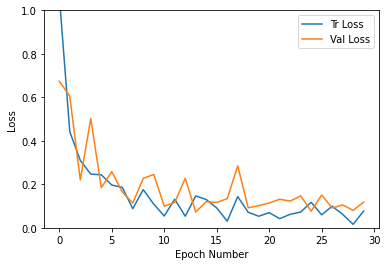

In [0]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('loss_curve.png')
plt.show()

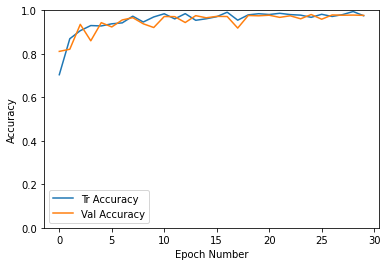

In [0]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

# Train resnet50 model



In [0]:
model = models.resnet50(pretrained=False)


In [0]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model.fc.in_features
 
model.fc = nn.Sequential(
    nn.Linear(in_features=fc_inputs, out_features=num_classes, bias=True),
    nn.LogSoftmax(dim=1)
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Convert model to be used on GPU
model = model.to(device)
print(device)
# Define Optimizer and Loss Function
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

cuda:0


In [0]:
dataset = 'cls_axiom1'
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 30 epochs
num_epochs = 60
trained_model, history = train_and_validate(model, loss_func, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/60
Epoch : 000, Training: Loss: 2.1485, Accuracy: 40.8912%, 
		Validation : Loss : 2.0565, Accuracy: 44.7074%, Time: 94.1373s
Epoch: 2/60
Epoch : 001, Training: Loss: 1.6708, Accuracy: 51.3976%, 
		Validation : Loss : 1.9020, Accuracy: 44.9704%, Time: 93.7283s
Epoch: 3/60
Epoch : 002, Training: Loss: 1.4222, Accuracy: 57.8099%, 
		Validation : Loss : 2.4473, Accuracy: 54.3721%, Time: 93.8269s
Epoch: 4/60
Epoch : 003, Training: Loss: 1.2335, Accuracy: 63.4495%, 
		Validation : Loss : 1.4131, Accuracy: 62.5904%, Time: 93.8507s
Epoch: 5/60
Epoch : 004, Training: Loss: 1.1155, Accuracy: 66.9023%, 
		Validation : Loss : 9.3233, Accuracy: 46.8113%, Time: 93.5932s
Epoch: 6/60
Epoch : 005, Training: Loss: 0.9170, Accuracy: 72.8050%, 
		Validation : Loss : 1.2999, Accuracy: 62.7219%, Time: 93.3464s
Epoch: 7/60
Epoch : 006, Training: Loss: 0.8297, Accuracy: 75.0247%, 
		Validation : Loss : 1.4260, Accuracy: 60.2893%, Time: 93.4543s
Epoch: 8/60
Epoch : 007, Training: Loss: 0.7566, Accura

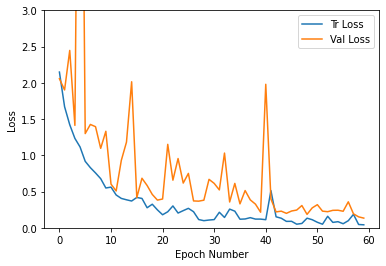

In [0]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.savefig('loss_curve.png')
plt.show()

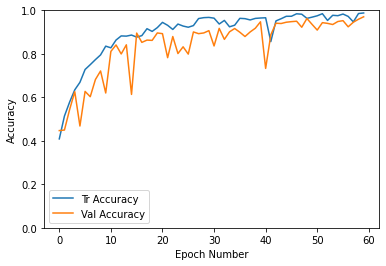

In [0]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

# Fine turning Vgg16 model

In [0]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

In [0]:
count = 0
for child in vgg16.features.children():
  count+=1
  if count < 16:
    for param in child.parameters():
      param.requires_grad = False


In [0]:
# Change the final layer of Vgg16 Model for Transfer Learning
 
vgg16.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=256, bias=True), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256, out_features=num_classes, bias=True),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Convert model to be used on GPU
vgg16 = vgg16.to(device)
print(device)
# Define Optimizer and Loss Function
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.NLLLoss()
optimizer = optim.Adam(vgg16.parameters())

cuda:0


In [0]:
dataset = 'cls_axiom_vgg16'
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 30 epochs
num_epochs = 30
trained_model, history = train_and_validate(vgg16, loss_func, optimizer, num_epochs)


Epoch: 1/30
Epoch : 000, Training: Loss: 2.3784, Accuracy: 32.5222%, 
		Validation : Loss : 2.0269, Accuracy: 42.0118%, Time: 88.8441s
Epoch: 2/30
Epoch : 001, Training: Loss: 1.8224, Accuracy: 46.2183%, 
		Validation : Loss : 1.7007, Accuracy: 51.0848%, Time: 88.3262s
Epoch: 3/30
Epoch : 002, Training: Loss: 1.6825, Accuracy: 48.7340%, 
		Validation : Loss : 1.3146, Accuracy: 55.2268%, Time: 88.7491s
Epoch: 4/30
Epoch : 003, Training: Loss: 1.4188, Accuracy: 56.3959%, 
		Validation : Loss : 1.3240, Accuracy: 58.0539%, Time: 89.2220s
Epoch: 5/30
Epoch : 004, Training: Loss: 1.3171, Accuracy: 59.6514%, 
		Validation : Loss : 1.1451, Accuracy: 61.4070%, Time: 89.3851s
Epoch: 6/30
Epoch : 005, Training: Loss: 1.2216, Accuracy: 63.3344%, 
		Validation : Loss : 1.0751, Accuracy: 65.1545%, Time: 89.8076s
Epoch: 7/30
Epoch : 006, Training: Loss: 0.9825, Accuracy: 69.8290%, 
		Validation : Loss : 0.8850, Accuracy: 73.5700%, Time: 90.1100s
Epoch: 8/30
Epoch : 007, Training: Loss: 0.8227, Accura

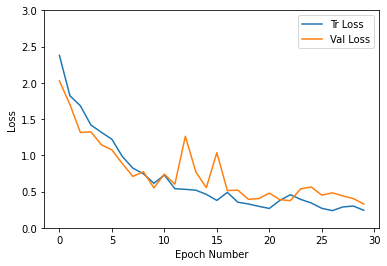

In [0]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.savefig('loss_curve.png')
plt.show()

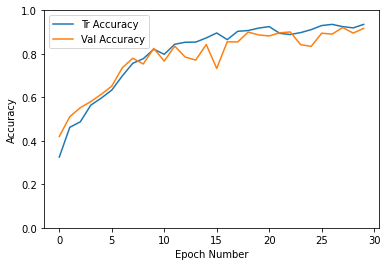

In [0]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()

# Train Vgg16 model

In [0]:
vgg16_model = models.vgg16(pretrained=False)

vgg16_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=256, bias=True), 
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=256, out_features=num_classes, bias=True),
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Convert model to be used on GPU
vgg16_model = vgg16_model.to(device)
print(device)
# Define Optimizer and Loss Function
# loss_func = nn.CrossEntropyLoss()
loss_func = nn.NLLLoss()
optimizer = optim.Adam(vgg16_model.parameters())

cuda:0


In [0]:
dataset = 'cls_axiom_vgg16_model'
# Print the model to be trained
# Train the model for 30 epochs
num_epochs = 60
trained_model, history = train_and_validate(vgg16_model, loss_func, optimizer, num_epochs)

Epoch: 1/60
Epoch : 000, Training: Loss: 3.7011, Accuracy: 27.1128%, 
		Validation : Loss : 2.1812, Accuracy: 31.2952%, Time: 246.3186s
Epoch: 2/60
Epoch : 001, Training: Loss: 2.1805, Accuracy: 33.2621%, 
		Validation : Loss : 2.5544, Accuracy: 23.5371%, Time: 246.1280s
Epoch: 3/60
Epoch : 002, Training: Loss: 2.0130, Accuracy: 37.5041%, 
		Validation : Loss : 1.8791, Accuracy: 43.2610%, Time: 245.0351s
Epoch: 4/60
Epoch : 003, Training: Loss: 1.8214, Accuracy: 44.6235%, 
		Validation : Loss : 1.8090, Accuracy: 48.3235%, Time: 243.6282s
Epoch: 5/60
Epoch : 004, Training: Loss: 1.6257, Accuracy: 51.3976%, 
		Validation : Loss : 1.4473, Accuracy: 57.8567%, Time: 243.2885s
Epoch: 6/60
Epoch : 005, Training: Loss: 1.4285, Accuracy: 58.4018%, 
		Validation : Loss : 1.2760, Accuracy: 64.2341%, Time: 243.1960s
Epoch: 7/60
Epoch : 006, Training: Loss: 1.2509, Accuracy: 63.6797%, 
		Validation : Loss : 1.1760, Accuracy: 66.8639%, Time: 243.4364s
Epoch: 8/60
Epoch : 007, Training: Loss: 1.1201,

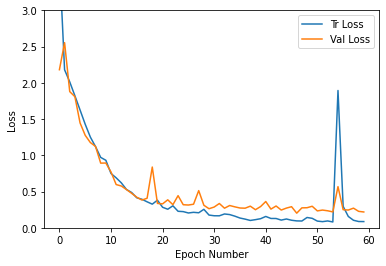

In [0]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,3)
plt.savefig('loss_curve.png')
plt.show()

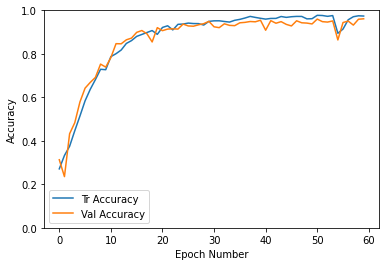

In [0]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('accuracy_curve.png')
plt.show()